In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("India_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(16):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))


In [ ]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("India_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast (Improved) ===
series = list(land_used[train_start-3:train_start])  # Start from 3 values before 2005
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict from 2008 to 2023
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA Prediction
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM Prediction
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU Prediction
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    # Append full feature set for stacking model
    stacked_features.append(pred_row)

    # ✅ Use average of all model predictions to update input series
    series.append(np.mean(pred_row))

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




In [ ]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("India_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]
actual = land_used[train_start + 3:train_end]

# === 5. Hyperparameter Tuning (optimized) ===
def tune_model(model, param_grid):
    grid = RandomizedSearchCV(model, param_grid, cv=3, n_iter=5, random_state=42, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3]
})

# === 6. Train LSTM & GRU with EarlyStopping ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=50, verbose=0, callbacks=[early_stop])

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=50, verbose=0, callbacks=[early_stop])

# === 7. ARIMA Forecast Once ===
arima_series = land_used[train_start-3:train_end]
model_arima = ARIMA(arima_series, order=(2, 1, 0))
fitted_arima = model_arima.fit()
arima_preds = fitted_arima.forecast(steps=len(pred_years)).tolist()

# === 8. Recursive Forecast with Ensemble ===
series = list(land_used[train_start-3:train_start])
preds = {name: [] for name in models}
lstm_preds, gru_preds = [], []
stacked_features = []

for i in range(len(pred_years)):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    arima_pred = arima_preds[i]
    pred_row.append(arima_pred)

    # LSTM
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    stacked_features.append(pred_row)
    series.append(np.mean(pred_row))

# === 9. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 11. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 12. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 13. Plot Actual vs Predictions ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 14. Triple Bar Plot for R2, RMSE, MAE ===
import seaborn as sns

metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



📊 Model Evaluation Table:
                         R2           RMSE            MAE
ARIMA             0.316522  236267.361420  185356.281748
Stacked Ensemble  0.999996     540.025515     438.425374
Random Forest     0.198404  255869.887014  185247.298186
Decision Tree    -0.153588  306949.437690  200723.468148
Gradient Boost    0.025779  282078.674684  189331.110761

📅 Year-wise Prediction Table:
  Year       Actual        ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 4.174600e+06 4.402647e+06      4.174965e+06   4.783772e+06      4944390.0    4.915724e+06
 2011 4.944390e+06 4.742057e+06      4.944325e+06   4.918350e+06      4944390.0    4.941627e+06
 2012 5.040000e+06 4.903554e+06      5.039446e+06   4.913174e+06      4990000.0    4.942514e+06
 2013 5.000000e+06 4.940060e+06      5.000110e+06   4.968880e+06      4990000.0    5.000079e+06
 2014 4.990000e+06 4.975888e+06      4.990834e+06   5.030417e+06      5057030.0    5.003696e+06
 2015 5.070000e+06 5.0

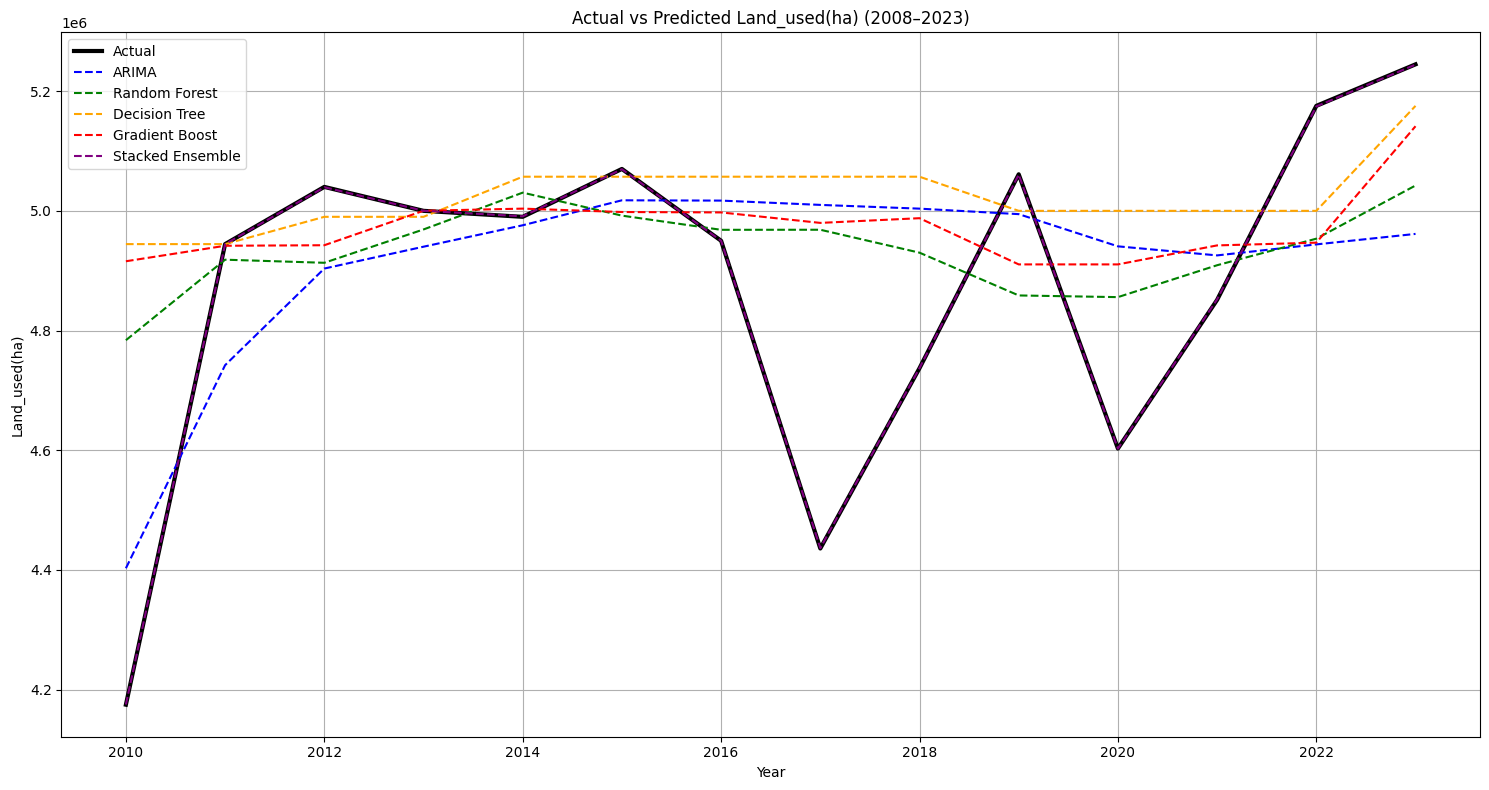

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("India_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
